In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import simulation_process
from keras.models import load_model
from importlib import reload
from PGAgent import PGAgent
import timeit

Using TensorFlow backend.


# 0. Load Data

In [3]:
data=pd.read_csv("long_term_maximum_CPU_usage.csv")
data_mem=pd.read_csv("long_term_maximum_mem_usage.csv")

In [4]:
data2=data_mem.fillna(0)
data2=np.array(data2)
data2=data2[:1000,:]
data1=data.fillna(0)
data1=np.array(data1)
data1=data1[:1000,:]
data1

array([[0.3555  , 0.3252  , 0.07507 , ..., 0.09277 , 0.02365 , 0.      ],
       [0.2617  , 0.3594  , 0.06982 , ..., 0.04437 , 0.003883, 0.01797 ],
       [0.3643  , 0.375   , 0.1321  , ..., 0.03149 , 0.      , 0.      ],
       ...,
       [0.4136  , 0.3296  , 0.      , ..., 0.006264, 0.      , 0.08936 ],
       [0.3589  , 0.3789  , 0.      , ..., 0.01743 , 0.      , 0.09485 ],
       [0.4141  , 0.2383  , 0.      , ..., 0.003605, 0.      , 0.03674 ]])

In [5]:
row_num=data1.shape[0]
col_num=data1.shape[1]

# 1. LSTM Prediction Model

In [6]:
lag=8;
model=load_model('lstm_model2.h5')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10)                480       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 11        
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# 2. Load Reinforcement Learning Model

In [10]:
PM_num=100;
state_size=PM_num
action_size=(PM_num-1)*3+1
agent=PGAgent(state_size,action_size)
agent.model=load_model("RL_100.h5")

C:\Users\zf7ja\Desktop\Prediction_Work1\src\PGAgent.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(50, input_shape=(100,), activation="relu", kernel_initializer="he_uniform")`
  model.add(Dense(50, input_shape=(self.state_size,),activation='relu', init='he_uniform'))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 298)               15198     
Total params: 20,248
Trainable params: 20,248
Non-trainable params: 0
_________________________________________________________________


# 3. Setup Initial Simulation Environment

In [30]:
# Environment Settings
PM_num=100;
VM_num=1000;
# PM Trace Generation
PM_data=np.zeros([row_num,PM_num])
PM_vm_list=[]
PM_vm_list1=PM_vm_list.copy()
PM_vm_list2=PM_vm_list.copy()
PM_vm_list3=PM_vm_list.copy()
PM_vm_list4=PM_vm_list.copy()
for i in range (PM_num):
    chosen_vm_num=np.random.randint(20)
    chosen_column=list(np.random.randint(col_num,size=chosen_vm_num))
    PM_vm_list.append(chosen_column)    
    PM_vm_list1.append(chosen_column.copy())
    PM_vm_list2.append(chosen_column.copy())
    PM_vm_list3.append(chosen_column.copy())
    PM_vm_list4.append(chosen_column.copy())

    for j in range( chosen_vm_num):
        PM_data[:,i]+=data1[:,chosen_column[j]]

# 4. Define VM Migration Policy( Domain Knowledge & RL)

In [31]:
def VM_migration_policy(PM_num,PM_next_workload, PM_next_workload_data,PM_vm_list):
    migration_num=0
    migration_list=[]
    for mm in range(PM_num):
        if PM_next_workload[mm]>0.8:
            migration_list.append(mm)
    for index in migration_list:
        margin=PM_next_workload[index]-0.5
        PM_migration_index=index
        migration_task_index,migration_task_load=simulation_process.find_task_migration(PM_migration_index,margin,PM_next_workload_data) 
        PM_Acception_load=min(PM_next_workload)+migration_task_load 
        if PM_Acception_load<0.7: 
            PM_acception_index=PM_next_workload.index(min(PM_next_workload))
            simulation_process.migration_process(PM_migration_index,migration_task_index,PM_acception_index,PM_vm_list,PM_next_workload_data,PM_next_workload)
            migration_num+=1
    return migration_num

In [33]:
def RL_train_epoch_exe(PM_num,state,PM_current_workload_data,PM_current_workload,PM_vm_list,PM_vm_list_status,train_status):
    agent.states, agent.probs, agent.gradients, agent.rewards = [], [], [], []
    mig_num=0
    overhead_time=0
    for i in range(PM_num):
        start=timeit.default_timer()
        NN_state=simulation_process.get_nn_state(state,i)
        time_spend=timeit.default_timer()-start
        if NN_state[0]==3:
            action,prob=agent.act(NN_state)
            state,reward,SLo=simulation_process.env_step(i,PM_current_workload_data,PM_current_workload,PM_vm_list,action,PM_vm_list_status)
            time_spend=timeit.default_timer()-start
            agent.remember(NN_state,action,prob,reward)
            mig_num+=1
        overhead_time=max(overhead_time,time_spend)
   # print(agent.rewards)
    #print(agent.states)
    if(len(agent.rewards)>0 and train_status==1):
        agent.train()
    agent.states, agent.probs, agent.gradients, agent.rewards = [], [], [], []
    SLo=len(list(filter(lambda x: x>0.95 , PM_current_workload)))
    return SLo,state,mig_num,overhead_time

# 5. Simluation Process

In [34]:
migration_num=0   # prediction migration using domain knowledge
migration_num1=0  # Active migration using domain knowledge
migration_num3=0  # Active Reinforcement Learning
migration_num4=0  # Prediction Reinforcement Learning
nonmigr_num=0

SLo_migration=0
SLo_migration1=0
SLo_migration3=0
SLo_migration4=0
SLo_nonmigr=0

time_spend_migration=0
time_spend_migration1=0
time_spend_migration3=0
time_spend_migration4=0
time_spend_nonmigr=0

for current_time in range(500):
    initial_time=10

    PM_current_workload_data, PM_current_workload=simulation_process.PM_current_workload(data1,PM_vm_list,initial_time+current_time,PM_num)
    PM_current_workload_data1, PM_current_workload1=simulation_process.PM_current_workload(data1,PM_vm_list1,initial_time+current_time,PM_num)
    PM_current_workload_data2, PM_current_workload2=simulation_process.PM_current_workload(data1,PM_vm_list2,initial_time+current_time,PM_num)
    PM_current_workload_data3, PM_current_workload3=simulation_process.PM_current_workload(data1,PM_vm_list3,initial_time+current_time,PM_num)
    PM_current_workload_data4, PM_current_workload4=simulation_process.PM_current_workload(data1,PM_vm_list4,initial_time+current_time,PM_num)
 
    SLo_migration+=len(list(filter(lambda x: x>0.95 , PM_current_workload)))
    SLo_migration1+=len(list(filter(lambda x: x>0.95, PM_current_workload1)))
    SLo_migration3+=len(list(filter(lambda x: x>0.95, PM_current_workload3)))
    SLo_migration4+=len(list(filter(lambda x: x>0.95, PM_current_workload4)))
    SLo_nonmigr+=len(list(filter(lambda x: x>0.95, PM_current_workload2)))

    ############prediction migration using domain knowledge#############
    start=timeit.default_timer()
    PM_next_workload_data, PM_next_workload= simulation_process.PM_workload_prediction(model,lag,data1,PM_vm_list,initial_time+current_time,PM_num)
    time_spend_migration+=(timeit.default_timer()-start)/1000
    start=timeit.default_timer()
    mig_num=VM_migration_policy(PM_num,PM_next_workload, PM_next_workload_data,PM_vm_list)
    migration_num+=mig_num
    time_spend_migration+=timeit.default_timer()-start
    
    ################Active migration using domain knowledge#############
    start=timeit.default_timer()
    mig_num1=VM_migration_policy(PM_num,PM_current_workload1, PM_current_workload_data1,PM_vm_list1)
    migration_num1+=mig_num1
    time_spend_migration1+=timeit.default_timer()-start
    
    ################Active Reinforcement Learning#################
    start=timeit.default_timer()
    state=simulation_process.observation_state(PM_current_workload3,1)
    SLo,state,mig_num3,time_spend=RL_train_epoch_exe(PM_num,state,PM_current_workload_data3,PM_current_workload3,PM_vm_list3,1,0)
    migration_num3+=mig_num3
    time_spend_migration3+=time_spend
    ################Prediction Reinforcement Learning################
    start=timeit.default_timer()
    PM_next_workload_data4, PM_next_workload4= simulation_process.PM_workload_prediction(model,lag,data1,PM_vm_list4,initial_time+current_time,PM_num)     
    time_spend_migration4+=(timeit.default_timer()-start)/1000
    start=timeit.default_timer()
    state4=simulation_process.observation_state(PM_next_workload4,1)
    SLo4,state4,mig_num4,time_spend=RL_train_epoch_exe(PM_num,state4,PM_next_workload_data4,PM_next_workload4,PM_vm_list4,1,0)
    migration_num4+=mig_num4
    time_spend_migration4+=time_spend


    print(current_time,SLo_migration,SLo_nonmigr,SLo_migration1,SLo_migration3,SLo_migration4)
    print(current_time,time_spend_migration,time_spend_migration1,time_spend_migration3,time_spend_migration4)

0 31 31 31 31 31
0 0.001553947699931996 0.0004862999999204476 0.0010179999999309075 0.002167330699953709
1 43 57 49 55 55
1 0.0029426304999360586 0.0008704000001671375 0.0026378000002296176 0.004323297400273986
2 52 83 65 80 75
2 0.004235891200100469 0.0012875000002168235 0.0038442000004579313 0.006117202000066754
3 64 114 83 107 101
3 0.005500312600125199 0.0016829000001052918 0.005375500000809552 0.008522305199859602
4 74 141 97 128 115
4 0.006735025100279927 0.0019299999999020656 0.006613900000957074 0.010752027700067173
5 82 166 108 145 130
5 0.00787226149998014 0.0021971999999550462 0.00770350000129838 0.01272150160018009
6 91 186 116 159 139
6 0.009044012900174949 0.0024304999997184495 0.008625200001461053 0.014944355800149878
7 101 216 129 176 152
7 0.010243918999978632 0.0026208999997834326 0.009886900001220056 0.017196178500251336
8 113 239 140 192 162
8 0.011383314599841014 0.002855899999758549 0.01100020000103541 0.01937156210018702
9 124 261 155 211 173
9 0.0126075287998719

76 1026 2234 1190 1176 1103
76 0.09806686240089128 0.025284600002123625 0.08872649999921123 0.16052791219859092
77 1037 2260 1206 1191 1115
77 0.09923618180072798 0.02554080000209069 0.09006649999946603 0.16267551069840647
78 1051 2289 1217 1202 1129
78 0.10038185030060275 0.0257544000019152 0.09080179999909888 0.16480104209804403
79 1063 2317 1228 1216 1137
79 0.10172597110063905 0.026106000001618668 0.09175909999930809 0.1665801652982168
80 1073 2337 1246 1226 1149
80 0.10296881720064127 0.02637350000168226 0.09247339999910764 0.1687938726981947
81 1087 2367 1262 1237 1163
81 0.10410473250091351 0.02664200000162964 0.09375149999914356 0.17093195359858962
82 1095 2390 1271 1248 1173
82 0.1052764878007151 0.026849900001707283 0.09467659999927491 0.17315633199898592
83 1103 2413 1284 1261 1183
83 0.10640319930071379 0.02706020000141507 0.09564289999934772 0.17570182469910012
84 1114 2434 1296 1270 1188
84 0.10752444930072576 0.027306300001328054 0.09634119999918767 0.17841104629912705
8

150 1989 4385 2347 2246 2050
150 0.18935316530030408 0.04746629999772267 0.16979390000005878 0.31394299699780776
151 2010 4417 2366 2264 2068
151 0.19073723900052378 0.04784109999764041 0.17068310000013298 0.3160202307974809
152 2024 4445 2381 2284 2085
152 0.19213378650040827 0.048047499997665 0.17222159999982978 0.31780984959758957
153 2035 4472 2397 2301 2096
153 0.19339991470014126 0.048374499997862586 0.17314279999982318 0.3202202754973218
154 2048 4503 2411 2322 2111
154 0.19464858870018986 0.04867069999818341 0.17415769999979602 0.3223166246971932
155 2061 4535 2428 2338 2125
155 0.1958994614004613 0.048967199998060096 0.17504689999941547 0.32457540039737837
156 2076 4565 2447 2353 2135
156 0.1971628036002238 0.0493317999980718 0.1762717999990855 0.32714033479741095
157 2091 4599 2467 2368 2147
157 0.19834389780052733 0.0495888999980707 0.17741129999876648 0.32977829289756566
158 2110 4632 2487 2380 2164
158 0.19954319530082093 0.04985969999779627 0.17842909999899348 0.331699574

224 2952 6549 3472 3398 2911
224 0.2818007651993297 0.07105499999761378 0.25258540000049834 0.4675455287965309
225 2961 6582 3487 3416 2921
225 0.2829645145992889 0.07127249999757623 0.2538688000008733 0.46947705669645834
226 2972 6610 3500 3429 2930
226 0.2841744734994425 0.07147539999778019 0.25540620000083436 0.47180957039625976
227 2984 6640 3512 3442 2941
227 0.28542605949928823 0.0716943999977957 0.25741520000065066 0.47428360349602355
228 3000 6666 3532 3456 2955
228 0.2866124592991253 0.07198079999807305 0.2582324000004519 0.4760240513957281
229 3015 6693 3550 3469 2968
229 0.2878402616987363 0.07225219999827459 0.25923850000026505 0.4780993159955213
230 3028 6724 3572 3484 2981
230 0.2890181341986548 0.07253689999834023 0.2603710000003048 0.48000536579537384
231 3040 6754 3585 3495 2992
231 0.2901768447984904 0.07272949999833145 0.2616153000003578 0.48212670549561
232 3052 6780 3596 3504 3004
232 0.2914028377984467 0.07298079999873153 0.2623902000000271 0.48386545869558933
233

299 3751 8533 4377 4386 3648
299 0.3723117410991154 0.09013779999850158 0.3364887999973689 0.6212413854944147
300 3765 8562 4391 4402 3662
300 0.373546908398851 0.090388899998743 0.3376954999971531 0.6238437675943654
301 3777 8585 4403 4416 3674
301 0.3747611580988251 0.09062479999874995 0.3384583999973074 0.6259353156942828
302 3787 8607 4412 4429 3681
302 0.3762035258986576 0.09095419999857768 0.339283999996951 0.6283945114942179
303 3803 8635 4425 4442 3692
303 0.3773129593988211 0.09126399999877322 0.34091259999695467 0.630412272194262
304 3812 8656 4430 4450 3697
304 0.3784782899989178 0.09141309999859004 0.3418366999967475 0.6321800715941329
305 3820 8680 4440 4461 3705
305 0.379706552798632 0.09157039999854533 0.34279479999668183 0.6347408321942192
306 3829 8701 4450 4475 3714
306 0.38094878859863235 0.09172349999835205 0.34437229999639385 0.6373044087938327
307 3843 8726 4465 4491 3723
307 0.38212183329853366 0.09197189999849797 0.3454132999963804 0.6391409272941094
308 3851 87

374 4455 10300 5086 5213 4276
374 0.4600569354984275 0.1063714999977492 0.4169435999970119 0.7742758977949062
375 4461 10318 5095 5220 4282
375 0.46115753319848574 0.10650499999746899 0.4177132999971036 0.7768392418947503
376 4465 10341 5098 5225 4285
376 0.46225552149834565 0.10664499999757027 0.4187683999971341 0.7791397356947866
377 4478 10365 5109 5237 4296
377 0.46358136839844316 0.10703939999757495 0.41983929999696556 0.7807995333947648
378 4487 10391 5116 5245 4302
378 0.46464826109847923 0.10719599999765705 0.420810699996764 0.7827943137949734
379 4492 10409 5126 5254 4307
379 0.4657614321984786 0.10742189999746188 0.42176239999662357 0.7847819105949194
380 4501 10430 5135 5261 4317
380 0.46695114749854044 0.10765939999737384 0.4226444999967498 0.7866911166949364
381 4509 10453 5142 5268 4324
381 0.46810475929812106 0.10787569999729385 0.4233938999968814 0.7888805904946855
382 4522 10479 5158 5282 4335
382 0.4692867461980857 0.10811179999700471 0.42463639999687075 0.79066213269

448 5023 11866 5668 5903 4833
448 0.5430175297979766 0.12082799999734561 0.4904160999967644 0.9155694759964302
449 5029 11886 5675 5908 4843
449 0.544156630697906 0.12098979999746007 0.49127769999677184 0.9176549630964681
450 5036 11907 5680 5918 4853
450 0.5453021841980956 0.12122149999731846 0.4924106999965261 0.9197322351962629
451 5042 11932 5683 5927 4859
451 0.5464448428980547 0.12139119999756076 0.49367899999651854 0.921778217196268
452 5050 11952 5690 5936 4869
452 0.5475739795980723 0.12156119999735893 0.4945147999965229 0.9234978584961058
453 5055 11971 5695 5942 4877
453 0.5487036183979541 0.12171519999719749 0.4953548999965278 0.92526685109576
454 5063 11989 5704 5949 4883
454 0.5498854420977697 0.12194419999696038 0.49615279999670747 0.9272643900959264
455 5073 12015 5714 5959 4895
455 0.5510628976978388 0.12211909999723503 0.4972488999965208 0.9300651330960468
456 5082 12034 5718 5968 4901
456 0.5523452070980999 0.12227779999739141 0.49905769999668337 0.9318080658962381
4

# 6. Metric Evalution

# (1). SLO Violation Rate

In [36]:
prediction_PM_SLO=SLo_migration/(500*PM_num)
No_mig_PM_SLO=SLo_nonmigr/(500*PM_num)
Act_PM_SLO1=SLo_migration1/(500*PM_num)
RL_PM_SLO=SLo_migration3/(500*PM_num)
pred_RL_PM_SLO=SLo_migration4/(500*PM_num)


In [38]:
SLA_Rate=[prediction_PM_SLO,Act_PM_SLO1,pred_RL_PM_SLO,RL_PM_SLO,No_mig_PM_SLO]

In [39]:
SLA_Rate

[0.1073, 0.1192, 0.10262, 0.12552, 0.2553]

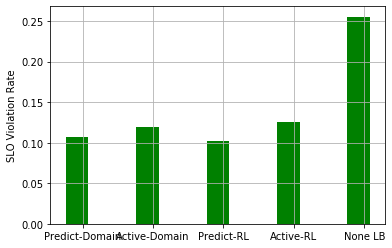

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
 
def draw_bar(labels,quants,name):
    width = 0.4
    ind = np.linspace(0,5,5)
    # make a square figure
    fig = plt.figure(1)
    ax  = fig.add_subplot(111)
    # Bar Plot
    ax.bar(ind-width/4,quants,width,color='green')
    # Set the ticks on x-axis
    ax.set_xticks(ind)
    ax.set_xticklabels(labels)
    # labels
    #ax.set_xlabel()
    ax.set_ylabel(name)
    # title
    #ax.set_title('Top 10 GDP Countries', bbox={'facecolor':'0.8', 'pad':5})
    plt.grid(True)
    plt.show()
    plt.savefig("SLA_Rate.jpg")
    plt.close()
 
labels   = ['Predict-Domain', 'Active-Domain','Predict-RL','Active-RL','None LB']
 
quants   = SLA_Rate
 
draw_bar(labels,quants,"SLO Violation Rate")


# (2). Migration Num

In [41]:
migration_num_list=[migration_num,migration_num1,migration_num4,migration_num3,0]

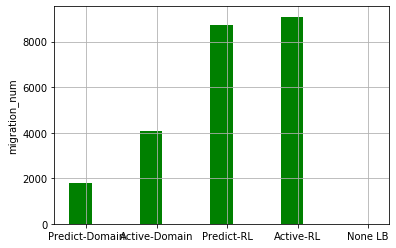

In [42]:
draw_bar(labels,migration_num_list,"migration_num")

# (3).  Overhead 

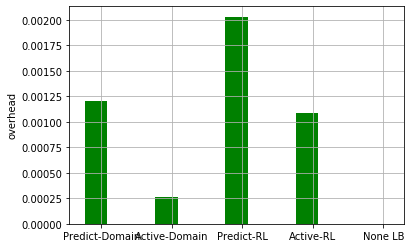

In [43]:
overhead_list=[time_spend_migration,time_spend_migration1,time_spend_migration4,time_spend_migration3,0]
overhead_list=np.array(overhead_list)/500
draw_bar(labels,overhead_list,"overhead")
